In [5]:
#НОРМЫ ПО ПОНЕДЕЛЬНИКАМ

import pandas as pd

# Загружаем нужные столбцы
cols = ['Номер из NAV','Адрес магазина','дата планового открытия','статус','ИФ кольца','ИФ КОЛЬЦА ОБРУЧ',
        'ИФ печатки','ИФ серьги','ИФ подвес культ','ИФ подвес декор','БК кольца','БК кольца обруч','БК печатки',
        'БК серьги','БК подвес культ','БК подвес декор','ИТОГО, нормы в штуках, без накоплений']

df = pd.read_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm',
    sheet_name='БАЗА',skiprows=2, usecols=cols)

# Убираем ненужную инфу
df.rename({'ИТОГО, нормы в штуках, без накоплений':"sum_all"}, axis=1, inplace=True)
df = df[df['sum_all'] > 0]
df['статус'] = df.статус.str.lower()
df = df[df.статус.isin(['открыт','склад','отгружен'])]

# Добавляем сумму по ИФ\БК и оставляем этот столбец вместо столбцов с нормами по иф\бк
sum_cols = [x for x in cols if 'ИФ' in x or 'БК' in x ]
df['sum_gold'] = df[sum_cols].sum(axis=1)
df.drop(axis=1, columns=sum_cols, inplace=True)

# Количество открытых и к открытию всего и только по золоту
shops_count = pd.DataFrame({
    'Магов открыто': [df.sum_all[df.статус !='склад'].count(), df.sum_gold[(df.sum_gold > 0) & (df.статус !='склад')].count()],
    'Магов к открытию': [df.sum_all[df.статус =='склад'].count(), df.sum_gold[(df.sum_gold > 0) & (df.статус =='склад')].count()],
    'Итого магов': [df.sum_all.count(),df.sum_gold[df.sum_gold > 0].count()]})

# Список новых магов с датами
new_shops = df[['Номер из NAV', 'Адрес магазина', 'дата планового открытия']][(df.sum_gold > 0) & (df.статус =='склад')]
new_shops.sort_values('дата планового открытия', inplace=True)

# Нормы ИФ/БК по ТПГ
row_number = pd.read_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm',
    sheet_name='НОРМЫ 17.12',skiprows=4,usecols=[5])

skip_row = row_number.ЦОК.tolist()
skip_row_n = skip_row.index('подгруппа')-1

norm_all = pd.read_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm',
    sheet_name='НОРМЫ 17.12',skiprows=4,nrows=skip_row_n)

lst = norm_all.columns.tolist()

cols = (
    [lst[lst.index('Название из NAV')]] +
    lst[lst.index(1001):lst.index(1102)+1] +
    lst[lst.index(1501):lst.index(1597)+1]
)
norm_all = norm_all[cols]
gold_shops = df[['Номер из NAV', 'статус']][df.sum_gold > 0]
merged = pd.merge(gold_shops, norm_all, left_on='Номер из NAV', right_on='Название из NAV', how = 'left')

del merged['Название из NAV'], merged['Номер из NAV']

# Все нецифры меняю на ноль. из ексель подтягивается значок '-'
nostatus = [i for i in merged.columns.to_list() if i !='статус']
merged[nostatus] = merged[nostatus].apply(pd.to_numeric, errors='coerce').fillna(0)


merged = merged.groupby(by='статус').sum()
merged = merged.T
merged['sum_all'] = merged.sum(axis=1)
merged = merged[['открыт', 'sum_all']]

# СОХРАНЯЕМ ВСЕ В 1 ФАЙЛ

with pd.ExcelWriter (
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\Отдел закупки\ЛИЧНЫЕ\Семен\нужное\для_новые_нормы.xlsx'
) as writer:
    shops_count.to_excel(writer, sheet_name='количество', index=False)
    new_shops.to_excel(writer, sheet_name='новые_маги', index=False)
    merged.to_excel(writer, sheet_name='новые_нормы')

In [1]:
#ДОСТАЕТ НОРМЫ ПО БУКВАМ И ЗОДИАКАМ 
import pandas as pd

# Читаем столбцы с нормами по буквам и зодиакам из реестра
cols = [2, *range(368,374), *range(469,475)]
link = r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm'    
norm = pd.read_excel(link, sheet_name='НОРМЫ 17.12', skiprows=4, usecols=cols)

# Обрезаем пустые строки, делим на буквы и зодиаки
last_row = norm.index[norm['Название из NAV'].isna()][0]-1
norm = norm.loc[:last_row]
norm.set_index('Название из NAV',inplace=True)

b_columns = [1088, 1089, 1090, 1586, 1587, 1588]
z_columns = [1091, 1092, 1093, 1589, 1590, 1591]
norm_b = norm[b_columns]
norm_z = norm[z_columns]

norm_b = norm_b.apply(pd.to_numeric, errors='coerce').fillna(0)
norm_z = norm_z.apply(pd.to_numeric, errors='coerce').fillna(0)

norm_b['sum_if'], norm_b['sum_bk'] = norm_b[[1088, 1089, 1090]].sum(axis=1), norm_b[[1586, 1587, 1588]].sum(axis=1)
norm_z['sum_if'], norm_z['sum_bk'] = norm_z[[1091, 1092, 1093]].sum(axis=1), norm_z[[1589, 1590, 1591]].sum(axis=1)

with pd.ExcelWriter (r'C:\Остатки\norm_bz.xlsx') as writer:
    norm_b.to_excel(writer, sheet_name='norm_b')
    norm_z.to_excel(writer, sheet_name='norm_z')

In [1]:
#ВЫДАЕТ СПИСОК АКТУАЛЬНЫХ МАГОВ ИФ\БК С НОРМАМИ ПО ТГ И ДАТЫ ОТКРЫТИЯ

import pandas as pd
import numpy as np
pd.set_option('use_inf_as_na', True)

#выгружаем датафрэйм с актуальными нормами ИФ БК из реестра магов 
cols_df = ['Номер из NAV', 'Адрес магазина', 'дата планового открытия','статус', 'ИФ кольца', 'ИФ КОЛЬЦА ОБРУЧ', 'ИФ печатки', 'ИФ серьги', 
        'ИФ подвес культ', 'ИФ подвес декор', 'БК кольца', 'БК кольца обруч', 'БК печатки', 'БК серьги', 
        'БК подвес культ', 'БК подвес декор']
      
df = pd.read_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm',
    sheet_name='БАЗА',skiprows=2, usecols=cols_df)

#выбираем открытые маги с суммой норм по иф/бк больше нуля
df = df[df.статус.str.contains('откр|отгр|склад', na=False, case=False)]
df['сумма'] = df.iloc[:, 3:].sum(axis=1)
df = df[df['сумма'] > 0]


all_shops = df.drop(columns=['статус','сумма','дата планового открытия'])
all_shops = all_shops.rename(columns={'Номер из NAV':'Код'})
all_shops['Код'] = all_shops['Код'].astype(np.int64)

# делим на два отдельных иф и бк
cols = all_shops.columns.tolist()
shops_if = all_shops[[*cols[:5],cols[7], cols[6], cols[5]]]
shops_bk = all_shops[[*cols[:2], *cols[8:11], cols[13],cols[12],cols[11]]]

#выгружаем из файла "наполняемость" актуальную структуру магов иф/бк, добавляет туда нормы и новые маги из датафрэйма выше
shops_if_list = pd.read_excel(
    r'C:\Остатки\наполняемость с 10012020.xlsx',
    sheet_name='ИФ', skiprows=3, usecols=[2],keep_default_na=False)

shops_bk_list = pd.read_excel(
    r'C:\Остатки\наполняемость с 10012020.xlsx',
    sheet_name='БК', skiprows=3, usecols=[2],keep_default_na=False)

# список новых магов которые надо добавить
add_to_if = pd.DataFrame({'Код':[x for x in shops_if['Код'].tolist() if x not in shops_if_list['Код'].tolist()]})
add_to_bk = pd.DataFrame({'Код':[x for x in shops_bk['Код'].tolist() if x not in shops_bk_list['Код'].tolist()]})

# добавляем новые маги в структуру
shops_if_list = shops_if_list.append(add_to_if, sort=False)
shops_bk_list = shops_bk_list.append(add_to_bk, sort=False)
all_shops_lst = list(set(shops_if_list.Код.tolist()).union(set(shops_bk_list.Код.tolist())))
all_shops_lst.append(7001)

#соединяем "структуру" и нормы добавляем итоги
shops_if = pd.merge(shops_if_list, shops_if, how='left', on='Код')
shops_bk = pd.merge(shops_bk_list, shops_bk, how='left', on='Код')

shops_if['Итого'] = shops_if.iloc[:, 1:].sum(axis=1)
shops_bk['Итого'] = shops_bk.iloc[:, 1:].sum(axis=1)

# загружаем и соединяем заборные листы и остатки
cols = ['КодСклада', 'СерийныйНомер', 'Тип1', 'ТоварноеНаправление']
stock = pd.read_csv(r'C:\анаконда\tmp.csv', delimiter=';', encoding='utf-8', usecols=cols)
stock = stock[stock.КодСклада.isin(all_shops_lst)]

stock_7001 = stock[stock.КодСклада == 7001]
stock = stock[stock.КодСклада != 7001]

zab = pd.read_excel(r'C:\анаконда\zab.xlsx', skiprows=4)
zab = zab[["Серийный Но.","Склад-приемник","Номер ЗЛ"]].sort_values(by="Номер ЗЛ",ascending = False)
zab.columns = ['СерийныйНомер','КодСклада','ЗЛ']
del zab['ЗЛ']
 
stock_7001 = stock_7001.drop(columns='КодСклада').merge(zab,on=['СерийныйНомер'],how = 'inner')

stock_full = pd.concat([stock_7001,stock])
stock_full.rename(columns={'КодСклада': 'Код'}, inplace=True)

# формируем одинаковые датасеты нормы-остатки, считаем наполняемость
k = ['КОЛЬЦО', 'СЕРЬГИ', 'ПОДВЕС ДЕКОРАТИВНЫЙ', 'ПОДВЕС КУЛЬТОВЫЙ', 
     'КОЛЬЦО ПЕЧАТКА', 'КОЛЬЦО ОБРУЧАЛЬНОЕ', 'ПИРСИНГ', 'СЕРЬГИ-КОНГО']

v = ['кольца', 'серьги', 'подвес декор', 'подвес культ',
     'печатки', 'КОЛЬЦА ОБРУЧ', 'серьги', 'серьги']

if_dict = {key: 'ИФ ' + value for key, value in zip(k,v)}#словарь для переименования тип1 в тг
bk_dict = {key: 'БК ' + value.lower() if value == 'КОЛЬЦА ОБРУЧ' else 'БК ' + value for key, value in zip(k,v)}

stock_full = stock_full[stock_full['Тип1'].isin(k)]

stock_if = stock_full[stock_full.ТоварноеНаправление == 'ИФ']
stock_if['Тип1'] = stock_if.Тип1.apply(lambda x: if_dict[x])
stock_if = stock_if.drop(columns='ТоварноеНаправление').pivot_table(index='Код', columns='Тип1', aggfunc='count')
stock_if.columns = stock_if.columns.droplevel(0)
stock_if.reset_index(inplace=True)
stock_if = shops_if[['Код']].merge(stock_if, on='Код', how='left')
stock_if.fillna(0, inplace=True)
stock_if['Итого'] = stock_if.iloc[:, 1:].sum(axis=1)

stock_bk = stock_full[stock_full.ТоварноеНаправление == 'БК']
stock_bk['Тип1'] = stock_bk.Тип1.apply(lambda x: bk_dict[x])
stock_bk = stock_bk.drop(columns='ТоварноеНаправление').pivot_table(index='Код', columns='Тип1', aggfunc='count')
stock_bk.columns = stock_bk.columns.droplevel(0)
stock_bk.reset_index(inplace=True)
stock_bk = shops_bk[['Код']].merge(stock_bk, on='Код', how='left')
stock_bk.fillna(0, inplace=True)
stock_bk['Итого'] = stock_bk.iloc[:, 1:].sum(axis=1)

if_cols = [x for x in shops_if.columns.tolist() if x != 'Адрес магазина']
bk_cols = [x for x in shops_bk.columns.tolist() if x != 'Адрес магазина']
stock_if = stock_if[if_cols]
stock_bk = stock_bk[bk_cols]

if_fillrate = stock_if.iloc[:, 1:] / shops_if.iloc[:, 2:]
#if_fillrate['Код'] = stock_if.iloc[:, 0]

bk_fillrate = stock_bk.iloc[:, 1:] / shops_bk.iloc[:, 2:]
#bk_fillrate['Код'] = stock_bk.iloc[:, 0]

shops_if = pd.concat([shops_if, stock_if.iloc[:, 1:], if_fillrate], axis=1)#для проверки
shops_bk = pd.concat([shops_bk, stock_bk.iloc[:, 1:], bk_fillrate], axis=1)#для проверки

#удаляем индекс и сохраняем на отдельные вкладки
shops_if.set_index('Код', drop=True,inplace=True)
shops_bk.set_index('Код', drop=True,inplace=True)

#создаем датафрейм из магов с датами открытия последние 90 дней
from datetime import date, timedelta

three_month_ago = date.today() - timedelta(90)
df['дата планового открытия'] = df['дата планового открытия'].apply(lambda x:x.date())#чтобы ошибка не выпадала о формате
dates = df[['Номер из NAV', 'дата планового открытия']][df['дата планового открытия'] > three_month_ago]
dates.set_index('Номер из NAV', drop=True,inplace=True)

#сохраняем все в эксель
with pd.ExcelWriter (
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\Отдел закупки\ЛИЧНЫЕ\Семен\актуальные маги.xlsx'
) as writer:
    shops_if.to_excel(writer, sheet_name='ИФ')
    shops_bk.to_excel(writer, sheet_name='БК')
    dates.to_excel(writer, sheet_name='даты')

C:\Users\Dotsenko.Semen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Dotsenko.Semen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1]:
# СПИСОК НОРМ ПО ТГ

import pandas as pd
import numpy as np

#читает файл с реестром
df = pd.read_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm',
    sheet_name='БАЗА',skiprows=2)

#вынимает нужные две строки и сохраняет
rep_tn = df.iloc[0:1,28:74]
rep_tn.to_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\Отдел закупки\ЛИЧНЫЕ\Татьяна ИФ.БК\РЕЙТИНГИ\Рейтинг ТГ и ТН\123.xlsx',
index=False)

In [1]:
#СЧИТАЕТ КОЛИЧЕСТВО МАГАЗОВ 3 МЕСЯЦА ДО СЕГОДНЯ И ПОСЛЕ

import pandas as pd
import numpy as np

df = pd.read_excel(
    r'\\gold585.int\uk\Общее хранилище файлов\Коммерческий департамент\реестр магазинов\РЕЕСТР МАГАЗИНОВ NEW.xlsm',
    sheet_name='БАЗА',skiprows=2, usecols=([2, 3, 6, 18] + list(range(28, 41))), parse_dates=[6] )

# выбираем маги с нужным статусом, с нормами по тн больше нуля 
df['статус'] = df.статус.str.lower()
df = df[df.статус.isin(['открыт','склад','отгружено'])]
df[['дата планового открытия']] = df['дата планового открытия'].fillna(df['дата планового открытия'].min())
df['sum'] = df.iloc[ : , 5:].sum(axis=1)
df = df[df['sum']>0]


In [3]:
df[['дата планового открытия']][df['дата планового открытия'] > '2020-07-01'].sort_values(['дата планового открытия'])


,дата планового открытия
947,2020-07-12
951,2020-08-01
950,2020-08-10
954,2020-08-10
952,2020-08-11
953,2020-08-25
968,2020-09-30
971,2020-10-01
967,2020-10-01
966,2020-10-01


In [ ]:
# ТОП 100 наполяем

registry_link = '//gold585.int/uk/Общее хранилище файлов\Коммерческий департамент\реестр магазинов'
top_link = 
row_number =
cols = 
tg_dic = 
tpg_norms = 

In [7]:
def one():
    return 1

def two ():
    return 2

func_dict = {1: one(), 2: two()}

In [9]:
func_dict[2]

2

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import seaborn as sns
sns.set()

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)


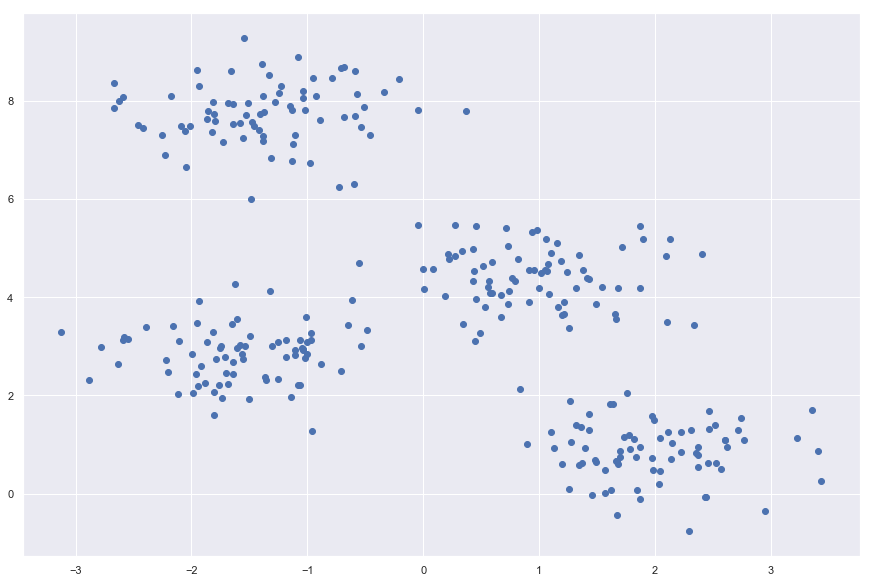

In [74]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(X[:, 0], X[:, 1])


In [85]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)

y_pred = model.fit_predict(X)

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        75
          1       0.00      0.00      0.00        75
          2       1.00      1.00      1.00        75
          3       0.00      0.00      0.00        75

avg / total       0.25      0.25      0.25       300



In [55]:
a = np.array([[10, 25, 12], [13, 14, 15]])

In [56]:
np.argmax(a)

1

In [54]:
a.flatten()[5]

15

In [61]:
rng = np.random.RandomState(2)
i = rng.permutation(X.shape[0])[:4]

In [62]:
i

array([ 98, 259, 184, 256])

In [65]:
X.shape[0]

300

In [66]:
rng.permutation(300)[:4]

array([289, 141, 131, 207])

In [68]:
centers = X[i]

In [69]:
from sklearn.metrics import pairwise_distances_argmin
pairwise_distances_argmin(X, centers)

array([3, 1, 0, 1, 3, 2, 3, 2, 1, 1, 3, 1, 2, 1, 3, 2, 2, 3, 3, 3, 2, 3,
       0, 3, 3, 2, 3, 2, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 2, 3, 0, 2,
       3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 2, 1, 3, 3, 3,
       1, 3, 1, 3, 2, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 3, 3, 1, 0, 3, 0,
       1, 1, 2, 3, 1, 3, 3, 2, 3, 2, 0, 3, 1, 3, 1, 3, 2, 3, 3, 0, 1, 0,
       3, 3, 3, 1, 3, 2, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 2, 3, 0, 3, 1, 2, 1, 1, 1, 2, 0, 2,
       3, 3, 1, 3, 3, 0, 1, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 1, 3, 0, 3, 1,
       2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 0, 2, 2, 1, 3, 3, 2, 2, 3, 3, 3, 2,
       3, 1, 2, 3, 3, 3, 2, 1, 3, 1, 2, 1, 2, 3, 2, 0, 1, 3, 3, 3, 3, 2,
       1, 3, 3, 3, 3, 3, 3, 1, 1, 0, 2, 1, 2, 3, 3, 2, 3, 3, 1, 3, 2, 2,
       2, 1, 1, 1, 1, 3, 3, 0, 0, 3, 3, 2, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3,
       1, 3, 2, 1, 0, 3, 3, 3, 3, 2, 2, 3, 3, 0, 1, 1, 2, 2, 2, 3, 3, 2,
       1, 3, 1, 2, 3, 3, 1, 1, 1, 3, 2, 2, 1, 3], d

In [70]:
labels = pairwise_distances_argmin(X, centers)

In [71]:
X[labels == 0]

array([[ 1.15521298,  5.09961887],
       [ 0.73436391,  5.03725437],
       [-0.04749204,  5.47425256],
       [ 0.93532512,  5.33179296],
       [ 0.42857674,  4.9739971 ],
       [ 0.27239604,  5.46996004],
       [ 1.3447177 ,  4.85711133],
       [ 0.98257009,  5.37530962],
       [ 0.45953467,  5.4498263 ],
       [ 1.86922139,  5.44132083],
       [-0.60133739,  6.29994922],
       [ 1.10123507,  4.88977075],
       [ 1.89593761,  5.18540259],
       [ 1.06269622,  5.17635143],
       [ 1.71444449,  5.02521524],
       [ 2.13003529,  5.1920962 ],
       [-0.73069817,  6.24208856],
       [ 2.40615694,  4.87047502],
       [ 0.71517795,  5.41334556],
       [ 2.09680545,  4.84741412]])

In [72]:
X[labels == 0].mean(0)

array([0.996244  , 5.28262763])

In [80]:
from scipy.stats import mode
a = np.array([[6, 8, 3, 0],
              [3, 2, 3, 7],
              [8, 1, 8, 4],
              [5, 3, 0, 5],
              [4, 7, 5, 9]])


In [81]:
mode(a)

ModeResult(mode=array([[3, 1, 3, 0]]), count=array([[1, 1, 2, 1]]))

In [82]:
np.zeros_like(4)

array(0)

In [83]:
from sklearn.datasets import load_digits
digits = load_digits()

In [87]:
model = KMeans(n_clusters=10, random_state=0)
clusters = model.fit_predict(digits.data)

In [91]:
len(clusters)

1797

In [94]:
len(np.zeros_like(clusters))

1797

In [98]:
for i in range(10):
    mask = (clusters == i)

In [101]:
lbls = np.zeros_like(clusters)
lbls[mask]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [102]:
digits.target[mask]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 8, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6])

In [103]:
np.arange(7)

array([0, 1, 2, 3, 4, 5, 6])

In [105]:
rng = np.random.RandomState(13)

In [107]:
a = rng.randn(2, 2)
a

array([[1.34510171, 0.53233789],
       [1.3501879 , 0.86121137]])

In [109]:
np.linalg.svd(a)

(array([[-0.66962567, -0.74269877],
        [-0.74269877,  0.66962567]]),
 array([2.14836999, 0.20464851]),
 array([[-0.88601942, -0.46364814],
        [-0.46364814,  0.88601942]]))

In [116]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

In [110]:
a = np.random.randn(20)
a


array([ 0.83809609,  0.12293672,  0.3589764 , -0.27179467,  0.36959616,
       -1.79061441,  0.24419577, -0.69676274, -0.62543   , -0.28428575,
       -1.75837978,  0.15390114,  0.58419753, -0.30550991, -2.28401991,
        0.42383861, -0.53735734,  2.13639097, -0.76864061, -0.81611596])

In [112]:
int(0.3 * 25)

7

In [114]:
a[3:] += 5

In [115]:
a

array([0.83809609, 0.12293672, 0.3589764 , 4.72820533, 5.36959616,
       3.20938559, 5.24419577, 4.30323726, 4.37457   , 4.71571425,
       3.24162022, 5.15390114, 5.58419753, 4.69449009, 2.71598009,
       5.42383861, 4.46264266, 7.13639097, 4.23135939, 4.18388404])

In [118]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

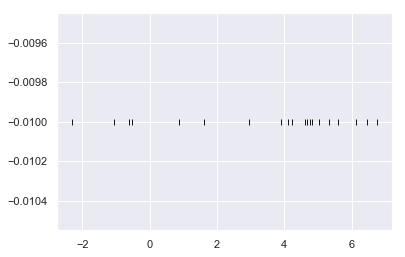

In [123]:
fig, ax = plt.figure(), plt.axes()
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

In [125]:
np.linspace(-5, 10, 10) + 0.06 


array([-4.94      , -3.27333333, -1.60666667,  0.06      ,  1.72666667,
        3.39333333,  5.06      ,  6.72666667,  8.39333333, 10.06      ])

In [126]:
from scipy.stats import norm


In [127]:
x


array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  6.74481176,  4.2387931 ,  5.3190391 ,  4.75062962,
        6.46210794,  2.93985929,  4.6775828 ,  4.61594565,  6.13376944,
        3.90010873,  4.82757179,  4.12214158,  5.04221375,  5.58281521])

In [129]:
norm(x[1]).pdf(np.linspace(-4, 8, 1000))

array([1.28238220e-03, 1.33555498e-03, 1.39073184e-03, 1.44797933e-03,
       1.50736581e-03, 1.56896153e-03, 1.63283863e-03, 1.69907118e-03,
       1.76773523e-03, 1.83890883e-03, 1.91267206e-03, 1.98910710e-03,
       2.06829821e-03, 2.15033183e-03, 2.23529653e-03, 2.32328315e-03,
       2.41438474e-03, 2.50869664e-03, 2.60631651e-03, 2.70734436e-03,
       2.81188257e-03, 2.92003593e-03, 3.03191170e-03, 3.14761957e-03,
       3.26727179e-03, 3.39098309e-03, 3.51887081e-03, 3.65105484e-03,
       3.78765773e-03, 3.92880464e-03, 4.07462342e-03, 4.22524461e-03,
       4.38080148e-03, 4.54143001e-03, 4.70726896e-03, 4.87845989e-03,
       5.05514713e-03, 5.23747783e-03, 5.42560199e-03, 5.61967243e-03,
       5.81984486e-03, 6.02627784e-03, 6.23913281e-03, 6.45857409e-03,
       6.68476890e-03, 6.91788735e-03, 7.15810246e-03, 7.40559012e-03,
       7.66052913e-03, 7.92310118e-03, 8.19349083e-03, 8.47188551e-03,
       8.75847552e-03, 9.05345401e-03, 9.35701692e-03, 9.66936304e-03,
      

In [133]:
x_d = np.linspace(-4, 8, 1000)
[norm(xi).pdf(x_d) for xi in x]

[array([5.39305398e-08, 5.76958057e-08, 6.17150455e-08, 6.60047516e-08,
        7.05824428e-08, 7.54667252e-08, 8.06773568e-08, 8.62353150e-08,
        9.21628685e-08, 9.84836529e-08, 1.05222751e-07, 1.12406775e-07,
        1.20063960e-07, 1.28224252e-07, 1.36919411e-07, 1.46183113e-07,
        1.56051060e-07, 1.66561100e-07, 1.77753341e-07, 1.89670287e-07,
        2.02356970e-07, 2.15861091e-07, 2.30233177e-07, 2.45526730e-07,
        2.61798402e-07, 2.79108162e-07, 2.97519490e-07, 3.17099560e-07,
        3.37919455e-07, 3.60054371e-07, 3.83583852e-07, 4.08592020e-07,
        4.35167829e-07, 4.63405324e-07, 4.93403917e-07, 5.25268676e-07,
        5.59110630e-07, 5.95047085e-07, 6.33201961e-07, 6.73706142e-07,
        7.16697845e-07, 7.62323006e-07, 8.10735688e-07, 8.62098504e-07,
        9.16583064e-07, 9.74370444e-07, 1.03565167e-06, 1.10062825e-06,
        1.16951269e-06, 1.24252907e-06, 1.31991363e-06, 1.40191539e-06,
        1.48879682e-06, 1.58083447e-06, 1.67831972e-06, 1.781559

In [135]:
np.exp(2)

7.38905609893065

In [136]:
2 ** 2,7

(4, 7)

In [139]:
2.718281 ** 2

7.389051594961001